In [1]:
from __future__ import division

from modules import * 
%matplotlib inline 

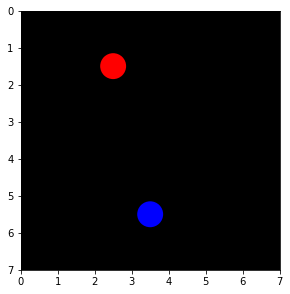

In [20]:
y_new = 7
x_new = 7
eu.height = y_new
eu.width = x_new
#make environment
maze = eu.gridworld([eu.height, eu.width],
                    rho        = eu.obs_rho,
                    num_pc     = eu.place_cells, 
                    pc_fwhm    = eu.fwhm, 
                    maze_type  = 'none', 
                    port_shift = eu.portshift)

for i in maze.rwd_loc: 
    maze.orig_rwd_loc.append(i)
#show environment
eu.make_env_plots(maze,1,0)

## test out gridworld wrapper. 
env = eu.gymworld(maze)

In [21]:
# MF module parameters
dims = [env.observation_space.shape[0],env.action_space.n]
MF = mf.AC_Net(dims)
discount_factor = 0.98

#learning parameters
eta = 5e-4 #gradient descent learning rate
opt = mf.optim.Adam(MF.parameters(), lr = eta)

# EC module parameters
## memory limit should be ~75% of #actions x #states
EC = ec.ep_mem(MF,int(0.75*np.prod(maze.grid.shape)*env.action_space.n))
use_EC = False
#----------------
# Run Parameters
#----------------
#trial parameters
NUM_TRIALS = 7000
NUM_EVENTS = 300

In [22]:
# prime run parameters
EC.reset_cache()
EC.reward_unseen = True 
add_mem_dict = {} #dictionary of items which get put into memory cache
timestamp = 0
success_benchmark = NUM_EVENTS*0.85 # average success before employing EC or removing most rewarded port

# data frames for value and policy maps
total_loss    = [[],[]]           # keep track of policy loss and value loss 
total_reward  = []                # keep track of rewards achieved per trial
val_maps      = []                # keep a list of state value arrays for each trial
value_map     = maze.empty_map    # array of state values
check_EC_pols = []                # keep track of policies stored by episodic cache

# flags to be changed mid run
rec_maps      = False
rwd_threshold = True

# --------------------------------
# optional settings for recording
# --------------------------------
add_episodic_cache = True
midrun_rwd_removal = False
track_occupancy    = False
track_MF_policies  = False
track_CS           = False

if midrun_rwd_removal: 
    reward_tally = {}
    for _ in maze.rwd_loc: 
        reward_tally[_] = []
    trial_rwd_switch = 0

if track_occupancy: 
    occ_list = []
if track_MF_policies:
    track_policy_dict = {}
if track_CS:
    track_confidence_score = [[],[]] #[[rewards],[computed confidence score]]

# record current time before beginning of trial
print_freq = 1/10
runtime = time.time()
blocktime = time.time()
print "Run started: "
#==================================
# Run Trial
#==================================

for trial in xrange(NUM_TRIALS):
    state       = Variable(torch.FloatTensor(env.reset()))
    reward_sum  = 0
    v_last      = 0
    reward_last = 0 
    trial_start = time.time()
    if track_occupancy:
        occupancy = np.zeros((eu.height, eu.width))
    
    for event in xrange(NUM_EVENTS):
        if track_occupancy:
            occupancy[maze.cur_state[1], maze.cur_state[0]] += 1
            
        # pass state through MF module
        policy_, value_ = MF(state)
        
        # pass state through EC module
        if use_EC:
            add_mem_dict['state'] = maze.cur_state
            #policy_EC = EC.recall_mem(tuple(state.data[0]))
            #policy_ = EC.composite_policy(policy_, policy_EC,reward)    # get policy composed of MF and EC outputs
        
        choice, policy, value = mf.select_action_end(MF,policy_, value_)
        
        if track_MF_policies:
            track_policy_dict[maze.cur_state] = policy, timestamp
        
        if event < NUM_EVENTS: 
            next_state, reward, done, info = env.step(choice)
        
        MF.rewards.append(reward)
        delta = reward_last + discount_factor*value - v_last  #compute eligibility trace/rpe approximation
        
        if use_EC:
            add_mem_dict['activity']  = tuple(state.data[0])
            add_mem_dict['action']    = choice
            add_mem_dict['delta']     = delta
            add_mem_dict['timestamp'] = timestamp            
            EC.add_mem(add_mem_dict,mixing=False)             #add event to memory cache
        
        if track_CS:
            track_confidence_score[0].append(reward)
            track_confidence_score[1].append(EC.confidence_score)
            EC.compute_confidence(reward)

        state = Variable(torch.FloatTensor(next_state))       # update state
        reward_sum += reward
        reward_last = reward

        v_last = value
        timestamp += 1
    
    if add_episodic_cache:
        if np.array(total_reward[-50:]).mean() > success_benchmark:
            if rwd_threshold:
                print " \t Started Memory at Trial ", trial
                if midrun_rwd_removal:
                    maxsums = {}
                    for item in reward_tally.items():
                        maxsums[item[0]] = sum(item[1])
                    most_rewarded_location = max(maxsums.iteritems(), key=operator.itemgetter(1))[0] 
                    maze.rwd_loc.remove(most_rewarded_location)
                    trial_rwd_switch = trial
                    print "removed reward at ", most_rewarded_location

                rwd_threshold = False
                use_EC = True

    if midrun_rwd_removal:
        if (trial_rwd_switch!=0) and (trial == trial_rwd_switch + 1000):
            maze.rwd_loc.append(most_rewarded_location)
   
    #--- AT end of trial, update weights     
    p_loss, v_loss = mf.finish_trial(MF, discount_factor,opt)
    
    total_loss[0].append(p_loss.data[0])
    total_loss[1].append(v_loss.data[0])
    total_reward.append(reward_sum)

    value_map = mf.generate_values(maze,MF,None)
    if use_EC:
        policy_map = mf.generate_values(maze, MF, EC)
        rec_maps = True
    val_maps.append(value_map.copy())    
    
    if rec_maps:
        check_EC_pols.append(policy_map.copy())
    
    if midrun_rwd_removal:
        for item in maze.reward_tally.items():
            reward_tally[item[0]].append(item[1])
    if track_occupancy:
        occ_list.append(occupancy.copy())
    
    # print reward measure
    if trial%(print_freq*NUM_TRIALS)==0 or trial == NUM_TRIALS-1: 
        print "[{0}]  Trial {1} total reward = {2} (Avg {3:.3f})".format(time.strftime("%H:%M:%S", time.localtime()), trial, reward_sum, float(reward_sum)/float(NUM_EVENTS)), "Block took {0:.3f}".format(time.time()-blocktime)
        blocktime = time.time() 
    
print "Run took {0:.3f}".format(time.time()-runtime)

Run started: 
[15:54:28]  Trial 0 total reward = 0 (Avg 0.000) Block took 0.171


/usr/lib/python2.7/dist-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/usr/lib/python2.7/dist-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


 	 Started Memory at Trial  332
[16:03:19]  Trial 700 total reward = 274 (Avg 0.913) Block took 530.442
[16:18:53]  Trial 1400 total reward = 287 (Avg 0.957) Block took 934.459
[16:34:27]  Trial 2100 total reward = 293 (Avg 0.977) Block took 934.298
[16:50:13]  Trial 2800 total reward = 299 (Avg 0.997) Block took 945.514
[17:05:50]  Trial 3500 total reward = 296 (Avg 0.987) Block took 937.085
[17:20:57]  Trial 4200 total reward = 293 (Avg 0.977) Block took 906.893
[17:36:19]  Trial 4900 total reward = 292 (Avg 0.973) Block took 922.605
[17:51:37]  Trial 5600 total reward = 297 (Avg 0.990) Block took 917.289
[18:06:58]  Trial 6300 total reward = 295 (Avg 0.983) Block took 921.820
[18:22:17]  Trial 6999 total reward = 295 (Avg 0.983) Block took 918.878
Run took 8869.457


In [7]:
if track_CS:
    plt.figure()
    plt.plot(track_confidence_score[0], 'r', label='rwd')
    plt.plot(track_confidence_score[1], 'b', label='cs')
    plt.legend(loc=0)
    plt.xlim([0, 8000])

    plt.show()
    plt.close()

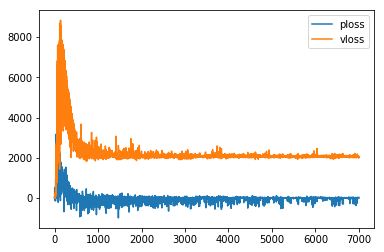

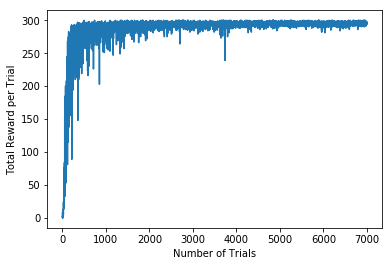

In [9]:
plt.figure(0)
plt.plot(total_loss[0], label='ploss')
plt.plot(total_loss[1], label='vloss')
plt.legend(loc=0)

plt.figure(1)
plt.plot(total_reward, label='rwd')
plt.xlabel("Number of Trials")
plt.ylabel("Total Reward per Trial")
if midrun_rwd_removal:
    plt.axvline(x=trial_rwd_switch, color='r')
    #plt.axvline(x=trial_rwd_switch+1000, color='r')

#plt.xlim([0,14000])
#plt.ylim([0,305])
#plt.legend(loc=0)
plt.show()

In [11]:
if midrun_rwd_removal:
    plt.figure(0)
    colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for i,item in enumerate(maze.orig_rwd_loc):
        plt.plot(reward_tally[item],colours[i], label="Port{}".format(item), alpha = 0.5)
    #plt.plot(reward_tally[1],'g', label="Port2", alpha = 0.5)
    #plt.plot(reward_tally[2],'r', label="Port3", alpha = 0.5)
    plt.legend(loc=0)
    #plt.xlim([1700,2000])
    #plt.ylim([0,50])
    plt.show()
    plt.close()

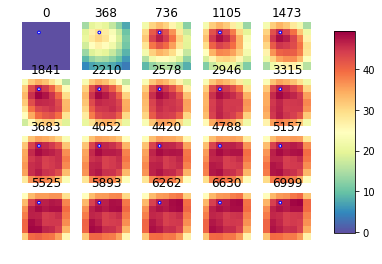

[(2, 1)]


In [12]:
eu.print_value_maps(maze,val_maps)
print maze.rwd_loc

2100000


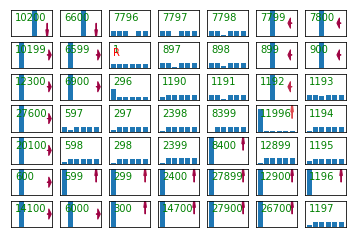

In [59]:
# policy maps in memory
print timestamp
if use_EC:
    import csv
    test_frame = [(v[2],v[0], v[1],eu.softmax(v[0]), maze.actionlist[np.argmax(eu.softmax(v[0]))], [x for _,x in sorted(zip(eu.softmax(v[0]),maze.actionlist), reverse=True)]) for (k,v) in EC.cache_list.items()]

    with open('mycsvfile.csv','wb') as f:
        w = csv.writer(f)
        w.writerows(test_frame)

    resultant_frame = {}
    for enum, i in enumerate(test_frame):
        resultant_frame[i[0]] = test_frame[enum][1:]


    plt.figure()
    fig, ax = plt.subplots(maze.grid.shape[0], maze.grid.shape[1])
    cmap = plt.cm.Spectral_r
    cNorm  = colors.Normalize(vmin=0, vmax=1)
    scalarMap = cm.ScalarMappable(norm = cNorm, cmap=cmap)

    for i in test_frame:
        state_loc = i[0]
        av = i[1]
        softmax = i[3]
        time_recorded = i[2]

        ax[state_loc[1], state_loc[0]].cla()
        ax[state_loc[1], state_loc[0]].bar(np.arange(6), softmax)
        arg_ = np.argmax(softmax)
        if softmax[arg_] > 0.65:
            dx1,dy1,_,__ = eu.make_arrows(arg_, softmax[arg_])
            colorVal1 = scalarMap.to_rgba(softmax[arg_])
            ax[state_loc[1], state_loc[0]].arrow(5,.5,dx1,dy1,head_width =0.4, head_length =0.4, color=colorVal1)
        ax[state_loc[1], state_loc[0]].set_xticks([])
        ax[state_loc[1], state_loc[0]].set_yticks([])
        ax[state_loc[1], state_loc[0]].set_ylim([0,1])
        ax[state_loc[1], state_loc[0]].annotate('{}'.format(timestamp -time_recorded), xy=(0,.6), color='g')
        if state_loc == maze.rwd_loc[0]:
            ax[state_loc[1], state_loc[0]].annotate('R', xy=(0,0.5), color='r')

    plt.savefig('7000t_ec.svg', format='svg')

    plt.show()
    plt.close()

In [60]:
track_policy_dict = {}
for __ in maze.useable:
    temp_state = Variable(torch.FloatTensor(maze.mk_state(state=__)))
    policy_, value_ = MF(temp_state)
    track_policy_dict[__] = np.array(policy_.data[0])
    
np.save('7000t_MFpolicies.npy', track_policy_dict)
np.save('7000t_ECpolicies.npy', EC.cache_list)

ValueError: incompatible sizes: argument 'height' must be length 6 or scalar

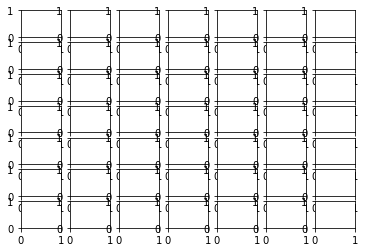

In [61]:
if track_MF_policies:
    plt.figure(figsize=(50,50))
    colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    fig, ax = plt.subplots(maze.grid.shape[0],  maze.grid.shape[1])
    for i in track_policy_dict:
        y_dim = i[0]
        x_dim = i[1]
        ax[i[1], i[0]].bar(np.arange(6), np.array(track_policy_dict[i][0]), label= track_policy_dict[i][1], alpha = 0.5, color='b') #what was generated by network
        ax[i[1], i[0]].bar(np.arange(6)+0.25, resultant_frame[i][2], alpha=0.5, color='g')#comparable entry in memory
        ax[i[1], i[0]].set_xticks([])
        ax[i[1], i[0]].set_yticks([])
        ax[i[1], i[0]].set_ylim([-1,1])
        if i == maze.rwd_loc[0]:
            ax[i[1], i[0]].annotate('R', xy=(0,0.5), color='r')
    plt.savefig('policies.svg', format='svg')
    plt.show()
    plt.close()

In [18]:
if use_EC:
    plt.figure()
    fig, ax = plt.subplots(maze.grid.shape[0], maze.grid.shape[1])
    visits = np.zeros(maze.grid.shape)
    time__ = np.zeros(maze.grid.shape)
    colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for i in test_frame:
        state_loc = i[0]
        av = i[1]
        #time = i[2]
        softmax = i[3]

        if i[2] > time__[state_loc[1],state_loc[0]]:
            ax[state_loc[1], state_loc[0]].cla()
            ax[state_loc[1], state_loc[0]].bar(np.arange(6), softmax, label=time, alpha = .8, color = colours[int(visits[state_loc[1],state_loc[0]])])
            ax[state_loc[1], state_loc[0]].set_xticks([])
            ax[state_loc[1], state_loc[0]].set_yticks([])
            ax[state_loc[1], state_loc[0]].set_ylim([0,1])
        else:
            pass

        visits[state_loc[1],state_loc[0]] += 1
        time__[state_loc[1],state_loc[0]] = i[2]

    plt.savefig('no_h_policies.svg',format='svg')
    plt.show()
    plt.close()

In [ ]:
if track_occupancy: 
    inde = 0
    plt.figure()
    plt.pcolor(occ_list[inde], cmap="Spectral_r", vmin=0, vmax = 300)
    plt.gca().invert_yaxis()
    plt.axes().set_aspect('equal', 'datalim')
    plt.colorbar()
    plt.show()
    plt.close()

In [ ]:
plt.close()
plt.figure()
eu.width = 5
eu.height = 5
for j, iterable in enumerate(check_EC_pols):
    if j < 25:
        fig, ax = plt.subplots(eu.width,eu.height)
        axes = np.ravel(ax)
        data = np.ravel(check_EC_pols[j])
        for i, item in enumerate(axes): 
            item.bar(np.arange(6), list(data[i]))
            item.set_ylim([0,1])
            item.set_yticks([])
            item.set_xticks([])
        plt.savefig('pol_tests/pol_test{}.svg'.format(j), format='svg')
        plt.close()

    elif j % 10 == 0: 
        fig, ax = plt.subplots(eu.height,eu.width)
        axes = np.ravel(ax)
        data = np.ravel(check_EC_pols[j])
        for i, item in enumerate(axes): 
            item.bar(np.arange(6), list(data[i]))
            item.set_ylim([0,1])
            item.set_yticks([])
            item.set_xticks([])
        plt.savefig('pol_tests/pol_test{}.svg'.format(j), format='svg')
        plt.close()
#plt.show()